# Caso 3: Good Reads 

## Sección Tercera: Análisis Predictivo

### Objetivos:

1. Una editorial nos ha contactado para ver qué parámetros debería tener un libro para que fuera exitoso. A partir del dataset y su análisis, orienta a la editorial sobre qué parámetros deben seguir a la hora de publicar un nuevo libro.

2. Diseña un modelo que, a partir de un libro de entrada, te recomiende una nueva lectura. Puedes utilizar o bien el dataset proporcionado o bien enriquecerlo (por ejemplo, utilizando técnicas de __webscrapping__, o añadiendo más atributos a los libros actuales).
 
3. Respecto a este sistema, a modo de ejemplo, explica las recomendaciones que proporcionaría el modelo si entráramos los siguientes libros: 
* "**A Court of Thorns and Roses**" de __Sarah J. Maas__
* "**Hamlet**" de __William Shakespeare__
* "**La Apología de Sócrates**" de __Platón__

### Metodología

1. Procesamiento de herramientas de webscrapping para obtener la data del sitio "**Good Reads**". Estas herramientas son los archivos `get_books.py` y `get_books_from_list.py`, que fueron suministrados con el ejercicio.
2. Agregar la data obtenida al dataset de good reads provisto por el ejercicio.
3. Procesar los archivos de metadata que están en formato __JSON__ para construir los dataframes necesarios para hacer el modelo de predicción.
4. Construir la matriz de similitud utilizando cosine_similarity
5. Crear la función de predicción

___

### Instalar dependencias

In [2]:
!pip install -r ./../requirements.txt


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 24.0
    Uninstalling pip-24.0:
      Successfully uninstalled pip-24.0


### Obtenemos los archivos de metadata para mayo y junio 2024

In [3]:
!python get_books_from_list.py --url_path https://www.goodreads.com/list/show/201106.Best_books_of_May_2024 --output_directory_path ./dataset/my_list_of_books_may.txt

https://www.goodreads.com/list/show/201106.Best_books_of_May_2024
./dataset/my_list_of_books_may.txt
50 retries  reached!!
100 books found
100 titles in the list! 🎉
50 retries  reached!!
8 books found
108 titles in the list! 🎉
2024-06-21 14:58:29.717501 get_books_from_list.py: 
  🎉 Success! All the books from the list have been scrapped. 🎉
  The list has been stored to /Users/edwinlopezariaz/UNI/ANALITICA-DATOS/casos-analitica-mbd/caso03/dataset/my_list_of_books_may.txt
  Goodreads scraping run time = ⏰ 0:00:22.720107 ⏰


In [4]:
!python get_books_from_list.py --url_path https://www.goodreads.com/list/show/202186.Best_books_of_June_2024 --output_directory_path ./dataset/my_list_of_books_jun.txt

https://www.goodreads.com/list/show/202186.Best_books_of_June_2024
./dataset/my_list_of_books_jun.txt
50 retries  reached!!
100 books found
100 titles in the list! 🎉
50 retries  reached!!
11 books found
111 titles in the list! 🎉
2024-06-21 14:58:59.799568 get_books_from_list.py: 
  🎉 Success! All the books from the list have been scrapped. 🎉
  The list has been stored to /Users/edwinlopezariaz/UNI/ANALITICA-DATOS/casos-analitica-mbd/caso03/dataset/my_list_of_books_jun.txt
  Goodreads scraping run time = ⏰ 0:00:14.088756 ⏰


In [ ]:
!python get_books.py --book_ids_path ./dataset/my_list_of_books_may.txt --output_directory_path ./data/classic_book_metadata

In [ ]:
!python get_books.py --book_ids_path ./dataset/my_list_of_books_jun.txt --output_directory_path ./data/classic_book_metadata

### Descomprimimos el dataset LSGoodReads 

In [5]:
from caso03.descomprimir_dataset import unzip_dataset
# Carga de datos
# Cargar dataset y descomprimir en /datos
unzip_dataset("./dataset/LSGoodReads.zip","./data")

Folder /Users/edwinlopezariaz/UNI/ANALITICA-DATOS/casos-analitica-mbd/caso03/data ya existe.
Unzipping ./dataset/LSGoodReads.zip...
File unzipped and saved to /Users/edwinlopezariaz/UNI/ANALITICA-DATOS/casos-analitica-mbd/caso03/data
Unzipped: ./dataset/LSGoodReads.zip


### Procesamos los archivos de metadata encontrados en __"./data/classic_book_metadata"__ y en __"./data/LSGoodReads"__

Definimos los imports y las funciones de uso general

In [1]:
import os
import re
import pandas as pd

def to_float(cell_value) -> float:
    if type(cell_value) == str and cell_value.isnumeric():
        return float(cell_value)
    elif type(cell_value) == str and cell_value.find("k") > -1:
        return float(cell_value.replace('k', ''))*1000
    elif type(cell_value) == int:
        return float(cell_value)
    return 0.0

def clean_text(cell_value) -> str:
    text = str(cell_value)                      # Convert the input text to string
    text = text.strip()
    text = text.lower()                         # Convert to lowercase
    text = re.sub(r'\s+', ' ', text)            # replace repeated blanks with a single one
    text = re.sub(r' ', '-', text)              # replace blanks with '-'
    text = re.sub(r'[^a-zA-Z0-9\-]', '', text)  # Remove special characters except for digits, letters and '-'
    return text

def list_to_str(a_list: list) -> str:
    if type(a_list) is list:
        another_list = sorted(a_list)
        another_list = [ clean_text(cell_value) for cell_value in list(set(another_list)) ]
        return " ".join(another_list)
    return ""

def get_books_metadata(path_to_json: str) -> pd.DataFrame:
    df = pd.read_json(path_to_json)
    df.set_index('book_id', inplace=True)
    
    # Guardamos el título original
    df['original_title'] = df['book_title'].apply(lambda title: str(title).strip())
    
    # Limpiamos textos
    for column_name in ['book_title', 'author', 'book_language', 'format']:
        df[column_name] = df[column_name].map(clean_text)            
    
    # Limpiar numéricos
    for column_name in ['num_pages', 'num_ratings', 'num_reviews', 'year_first_published', 'people_curr_read', 'peop_want_to_read']:
        df[column_name] = df[column_name].map(to_float)

    # Limpiar listas
    for column_name in ['book_series', 'book_settings', 'book_characters', 'genres', 'awards']:
        df[column_name] = df[column_name].map(list_to_str)            

    # Limpiar ratings in rating_distribution
    df['positive_ratings'] = 0.0
    df['negative_ratings'] = 0.0
    for index, row in df.iterrows():
        reviews = row['rating_distribution']
        positive_ratings = 0.0
        negative_ratings = 0.0
        if reviews:
            positive_ratings = float(reviews['5 Stars']) + float(reviews['4 Stars']) + float(reviews['3 Stars'])
            negative_ratings = float(reviews['2 Stars']) + float(reviews['1 Star'])
        df.loc[index, 'positive_ratings'] = positive_ratings
        df.loc[index, 'negative_ratings'] = negative_ratings

    # remove not needed columns
    df.drop(['book_id_title', 'cover_image_uri', 'authorlink', 'rating_distribution'], inplace=True, axis=1)
    return df

**Exploramos los datos cargados de "classic_book_metadata"**

In [2]:
classics_all_books_path = os.path.abspath(
    os.path.join('./data/classic_book_metadata', 'all_books.json')
)
books_df = pd.DataFrame(get_books_metadata(classics_all_books_path))
print(books_df.shape)
print(books_df.dtypes)
books_df.head(50)

(218, 19)
book_title               object
book_series              object
book_settings            object
book_characters          object
book_language            object
year_first_published    float64
author                   object
num_pages               float64
format                   object
genres                   object
people_curr_read        float64
peop_want_to_read       float64
num_ratings             float64
num_reviews             float64
average_rating          float64
awards                   object
original_title           object
positive_ratings        float64
negative_ratings        float64
dtype: object


,book_title,book_series,book_settings,book_characters,book_language,year_first_published,author,num_pages,format,genres,people_curr_read,peop_want_to_read,num_ratings,num_reviews,average_rating,awards,original_title,positive_ratings,negative_ratings
book_id,,,,,,,,,,,,,,,,,,,
196774367,the-boo-hag-flex,,,,,2024.0,justina-ireland,208.0,hardcover,middle-grade horror juvenile childrens fantasy,0.0,0.0,38.0,13.0,4.08,,The Boo Hag Flex,38.0,0.0
201730086,an-intrigue-of-witches,,,,,2024.0,esme-addison,288.0,kindle-edition,paranormal magic fiction historical-fiction wi...,0.0,0.0,188.0,107.0,3.63,,An Intrigue of Witches,163.0,25.0
175256709,skies-over-caledonia,,,,,2024.0,samantha-young,342.0,kindle-edition,romantic-suspense suspense scotland family con...,486.0,11500.0,2574.0,485.0,4.33,,Skies Over Caledonia,2520.0,54.0
195886568,the-dangerous-ones,,,,,2024.0,lauren-blackwood,368.0,hardcover,young-adult young-adult-fantasy historical-fic...,0.0,0.0,494.0,313.0,3.45,,The Dangerous Ones,417.0,77.0
198123560,the-ride-of-her-life,,,,,2024.0,jennifer-dugan,352.0,paperback,adult lesbian romance fiction queer contempora...,0.0,0.0,490.0,212.0,3.77,,The Ride of Her Life,451.0,39.0
197036035,that-night-in-the-library,,,,,2024.0,eva-jurczyk,288.0,paperback,horror adult books-about-books thriller fictio...,0.0,0.0,466.0,306.0,2.79,,That Night in the Library,282.0,184.0
199798143,love-lies-and-cherry-pie,,,,,2024.0,jackie-lau,342.0,paperback,adult romance fiction canada contemporary-roma...,0.0,0.0,870.0,408.0,3.62,,"Love, Lies, and Cherry Pie",794.0,76.0
198688449,moonstorm,,,,,2024.0,yoon-ha-lee,352.0,hardcover,young-adult science-fiction-fantasy fiction qu...,0.0,0.0,85.0,44.0,3.49,,Moonstorm,71.0,14.0
200575958,wander-lost,,,,,2024.0,laura-martin,368.0,hardcover,fantasy middle-grade,0.0,0.0,10.0,6.0,4.00,,Wander Lost,10.0,0.0


**Exploramos los libros de "LSGoodReads"**

In [3]:
goodreads_all_books_path = os.path.abspath(
    os.path.join('./data/LSGoodReads', 'all_books.json')
)
books_df = pd.concat([books_df, pd.DataFrame(get_books_metadata(goodreads_all_books_path))]) 
print(books_df.shape)
print(books_df.dtypes)
books_df.head(100)

(5874, 19)
book_title               object
book_series              object
book_settings            object
book_characters          object
book_language            object
year_first_published    float64
author                   object
num_pages               float64
format                   object
genres                   object
people_curr_read        float64
peop_want_to_read       float64
num_ratings             float64
num_reviews             float64
average_rating          float64
awards                   object
original_title           object
positive_ratings        float64
negative_ratings        float64
dtype: object


,book_title,book_series,book_settings,book_characters,book_language,year_first_published,author,num_pages,format,genres,people_curr_read,peop_want_to_read,num_ratings,num_reviews,average_rating,awards,original_title,positive_ratings,negative_ratings
book_id,,,,,,,,,,,,,,,,,,,
196774367,the-boo-hag-flex,,,,,2024.0,justina-ireland,208.0,hardcover,middle-grade horror juvenile childrens fantasy,0.0,0.0,38.0,13.0,4.08,,The Boo Hag Flex,38.0,0.0
201730086,an-intrigue-of-witches,,,,,2024.0,esme-addison,288.0,kindle-edition,paranormal magic fiction historical-fiction wi...,0.0,0.0,188.0,107.0,3.63,,An Intrigue of Witches,163.0,25.0
175256709,skies-over-caledonia,,,,,2024.0,samantha-young,342.0,kindle-edition,romantic-suspense suspense scotland family con...,486.0,11500.0,2574.0,485.0,4.33,,Skies Over Caledonia,2520.0,54.0
195886568,the-dangerous-ones,,,,,2024.0,lauren-blackwood,368.0,hardcover,young-adult young-adult-fantasy historical-fic...,0.0,0.0,494.0,313.0,3.45,,The Dangerous Ones,417.0,77.0
198123560,the-ride-of-her-life,,,,,2024.0,jennifer-dugan,352.0,paperback,adult lesbian romance fiction queer contempora...,0.0,0.0,490.0,212.0,3.77,,The Ride of Her Life,451.0,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199216118,secrets-of-rose-briar-hall,,,,,2024.0,kelsey-james,304.0,paperback,adult thriller fiction historical-fiction myst...,0.0,0.0,94.0,60.0,4.06,,Secrets of Rose Briar Hall,87.0,7.0
195830876,deaths-country,,,,,2024.0,rm-romero,400.0,hardcover,young-adult poetry magical-realism romance que...,0.0,0.0,177.0,100.0,3.97,,Death's Country,165.0,12.0
195830830,the-z-word,,,,,2024.0,lindsay-king-miller,256.0,paperback,horror adult lesbian fiction queer zombies lgbt,0.0,0.0,568.0,197.0,3.64,,The Z Word,510.0,58.0


#### Conclusiones de la exploración
Después de esta corta exploración, observamos que la data es de buena calidad, y es posible realizar los siguientes procesos.

___

### Pregunta 1:

**Una editorial nos ha contactado para ver qué parámetros debería tener un libro para que fuera exitoso. A partir del dataset y su análisis, orienta a la editorial sobre qué parámetros deben seguir a la hora de publicar un nuevo libro.**

Para contestar esta pregunta necesitamos encontrar cuáles serían las categorías de mayor relevancia del dataset utilizado. Para eso, utilizaremos una regresión logística sobre el campo de tensores. Pero antes necesitamos encontrar la matriz de similitud de dichos tensores para clasificarlos y darles un peso que nos sirva de punto de partida. Se utilizará el método "similitud por distancia de cosenos (cosine_similarity)".

array([[<Axes: title={'center': 'year_first_published'}>,
        <Axes: title={'center': 'num_pages'}>,
        <Axes: title={'center': 'people_curr_read'}>],
       [<Axes: title={'center': 'peop_want_to_read'}>,
        <Axes: title={'center': 'num_ratings'}>,
        <Axes: title={'center': 'num_reviews'}>],
       [<Axes: title={'center': 'average_rating'}>,
        <Axes: title={'center': 'positive_ratings'}>,
        <Axes: title={'center': 'negative_ratings'}>]], dtype=object)

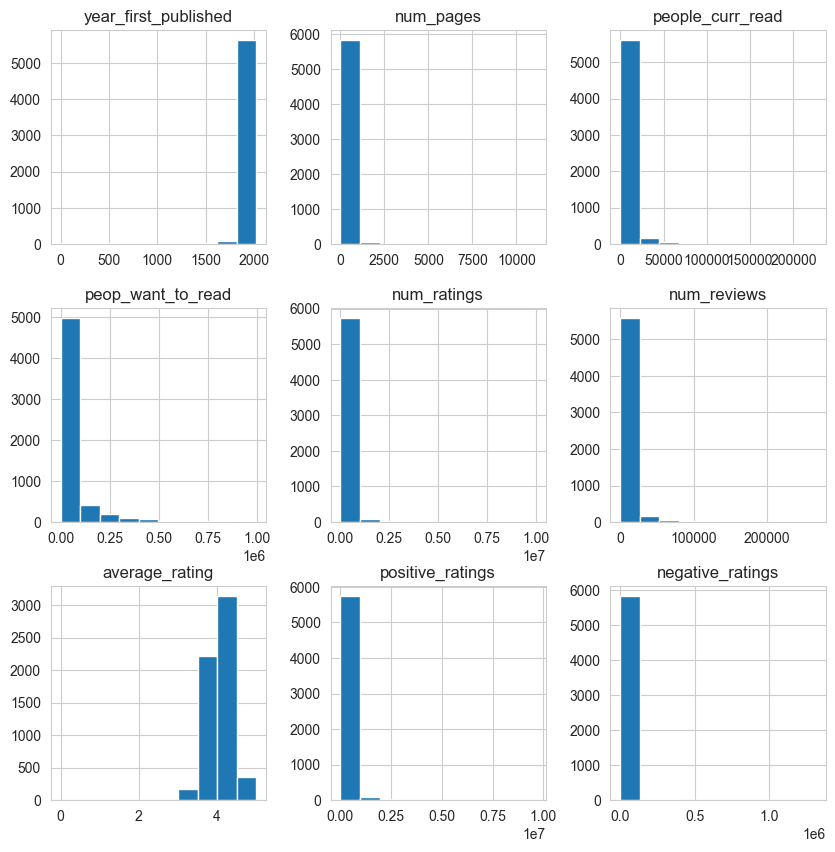

In [10]:
# Revisamos la distribución de las variables numéricas   
books_df.hist(figsize = (10, 10))

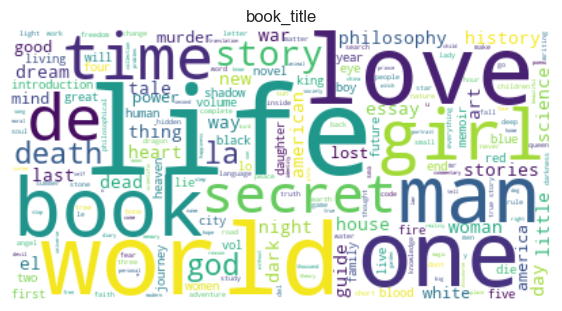

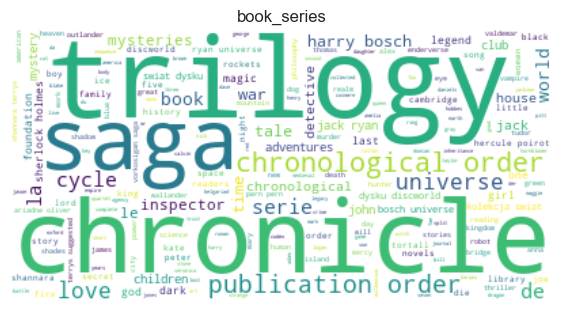

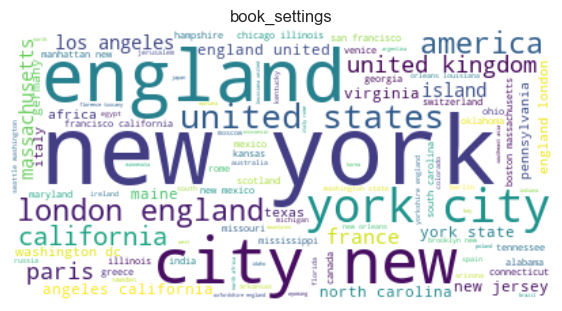

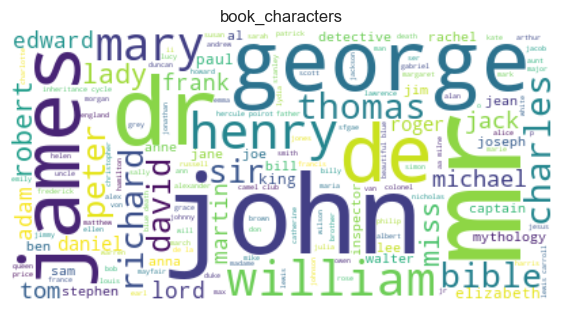

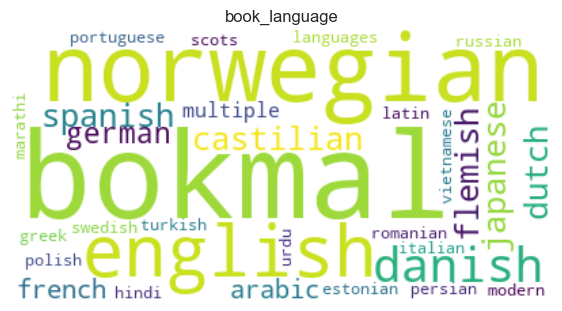

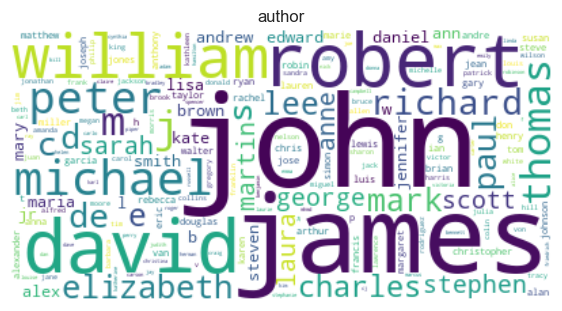

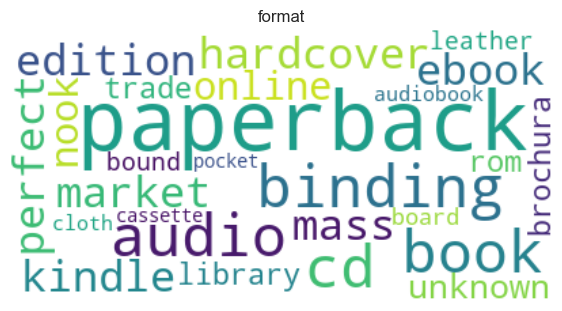

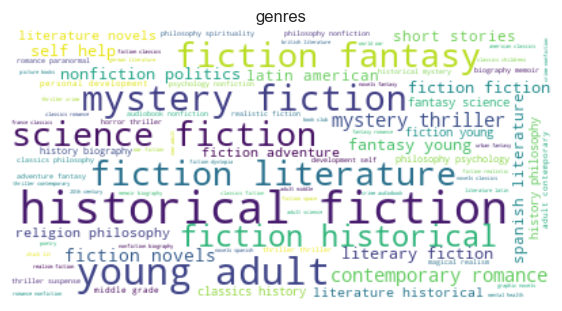

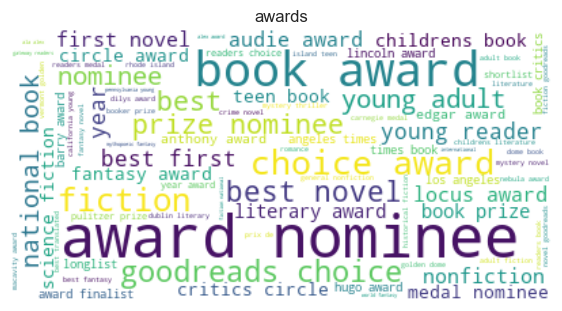

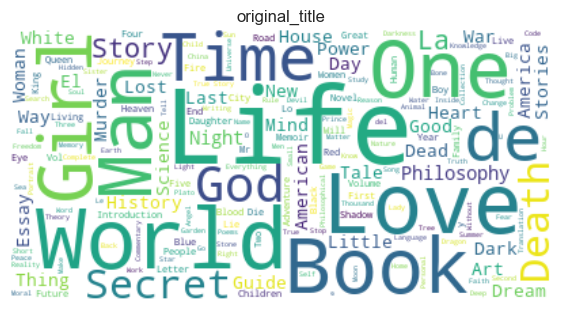

In [11]:
# Nos hacemos una idea general de las variables categóricas
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_word_cloud(text_column, column_name):
    wordcloud = WordCloud(background_color='white').generate(' '.join(text_column.unique()))
    plt.figure(figsize=(7,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(column_name)
    plt.show()

for column_name in books_df.select_dtypes(include='object').columns.tolist():
    generate_word_cloud(books_df[column_name], column_name)

___

Preparamos la data para crear el tensor requerido para calcular la matriz de similitud del coseno

In [4]:
# Rellenamos los vacíos.
for column_name in books_df.select_dtypes(include='number').columns:
    books_df[column_name] = books_df[column_name].fillna(0.0)

# Calculamos la bolsa de tokens para la matriz 
books_df['book_tokens'] = ""
for index, row in books_df.iterrows():
    data = [row[column_name] for column_name in books_df.select_dtypes(include=['object']).columns]
    data = map(lambda tokens: re.sub(r'[\-]', ' ', tokens), data) 
    cell = " ".join([item for item in data if item != ""])
    books_df.loc[index, 'book_tokens'] = cell.strip()

books_df[['book_title','book_tokens']].head(10)


,book_title,book_tokens
book_id,,
196774367,the-boo-hag-flex,the boo hag flex justina ireland hardcover mid...
201730086,an-intrigue-of-witches,an intrigue of witches esme addison kindle edi...
175256709,skies-over-caledonia,skies over caledonia samantha young kindle edi...
195886568,the-dangerous-ones,the dangerous ones lauren blackwood hardcover ...
198123560,the-ride-of-her-life,the ride of her life jennifer dugan paperback ...
197036035,that-night-in-the-library,that night in the library eva jurczyk paperbac...
199798143,love-lies-and-cherry-pie,love lies and cherry pie jackie lau paperback ...
198688449,moonstorm,moonstorm yoon ha lee hardcover young adult sc...
200575958,wander-lost,wander lost laura martin hardcover fantasy mid...


In [5]:
# Creamos las funciones para obtener la metadata a partir del título
def get_book_id_by_title(df: pd.DataFrame, book_title:str) -> int|None:
    # probar primero contra título original:
    book_index = df.index[df['original_title'] == book_title].tolist()
    if book_index:
        return book_index[0]    
    # Luego contra el título preprocesado    
    title_transformed = clean_text(book_title)
    book_index = df.index[df['book_title'] == title_transformed].tolist()
    if book_index:
        return book_index[0]
    # No se encontró
    return None

def get_book_original_title_by_id(df: pd.DataFrame, book_id:int) -> str|None:
    if not df.loc[book_id].empty:
        return df.loc[book_id]['original_title']
    return None

def get_book_title_by_id(df: pd.DataFrame, book_id:int) -> str|None:
    if not df.loc[book_id].empty:
        return df.loc[book_id]['book_title']
    return None

In [14]:
# Probamos las funciones creadas con:
#   "A Court of Thorns and Roses" de Sarah J. Maas
#   "Hamlet" de William Shakespeare
#   "La Apología de Sócrates" de Platón

print(clean_text("A Court of Thorns and Roses"))
print(clean_text("Hamlet"))
print(clean_text("La Apologia de Socrates"))
print(clean_text("La Apología de Sócrates"))

print(get_book_id_by_title(books_df, "A Court of Thorns and Roses"))
print(get_book_id_by_title(books_df, "La Apologia de Socrates"))
print(get_book_id_by_title(books_df, "La Apología de Sócrates"))
print(get_book_id_by_title(books_df, "Hamlet"))
print(get_book_original_title_by_id(books_df, 1420))
books_df.query(f"original_title=='Hamlet'")

a-court-of-thorns-and-roses
hamlet
la-apologia-de-socrates
la-apologa-de-scrates
None
None
None
1420
Hamlet


,book_title,book_series,book_settings,book_characters,book_language,year_first_published,author,num_pages,format,genres,people_curr_read,peop_want_to_read,num_ratings,num_reviews,average_rating,awards,original_title,positive_ratings,negative_ratings,book_tokens
book_id,,,,,,,,,,,,,,,,,,,,
1420,hamlet,,denmark,ophelia bernardo marcellus osric claudius-king-of-denmark gertrude horatio voltimand cornelius hamlet laertes polonius fortinbras rosencrantz-and-guildenstern francisco reynaldo,english,1601.0,william-shakespeare,289.0,paperback,plays fiction literature school theatre drama classics,26200.0,343000.0,947560.0,22034.0,4.02,grammy-award-nominee-for-best-spoken-word-album-2012,Hamlet,878474.0,69086.0,hamlet denmark ophelia bernardo marcellus osric claudius king of denmark gertrude horatio voltimand cornelius hamlet laertes polonius fortinbras rosencrantz and guildenstern francisco reynaldo english william shakespeare paperback plays fiction literature school theatre drama classics grammy award nominee for best spoken word album 2012 Hamlet


In [6]:
# Calculamos el tensor de la variable categórica: 'book_tokens' como matriz dispersa:
from sklearn.feature_extraction.text import TfidfVectorizer

categorical_attrs_df = books_df['book_tokens'].copy()
tfidf_vectorizer=TfidfVectorizer()
tfidf_vectors=tfidf_vectorizer.fit_transform(categorical_attrs_df)

In [7]:
# Características de la variable categórica 'book_tokens' por book_id.
tensor_categorical_df = pd.DataFrame(
    tfidf_vectors.todense(),
    index=categorical_attrs_df.index,
    columns=tfidf_vectorizer.get_feature_names_out()
)
tensor_categorical_df.head()

,000,10,100,101,101st,102,10th,11,110,1111,...,zunski,zuo,zurich,zusak,zvi,zweig,zybyy,zyl,zyr,zyz
book_id,,,,,,,,,,,,,,,,,,,,,
196774367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201730086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
175256709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
195886568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198123560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Obtenemos una copia de las variables numéricas para calcular el tensor.
numerical_columns = [column_name for column_name in books_df.select_dtypes(include=['Float64']).columns]
number_attrs_df = books_df[numerical_columns].copy()
number_attrs_df.head()

,year_first_published,num_pages,people_curr_read,peop_want_to_read,num_ratings,num_reviews,average_rating,positive_ratings,negative_ratings
book_id,,,,,,,,,
196774367,2024.0,208.0,0.0,0.0,38.0,13.0,4.08,38.0,0.0
201730086,2024.0,288.0,0.0,0.0,188.0,107.0,3.63,163.0,25.0
175256709,2024.0,342.0,486.0,11500.0,2574.0,485.0,4.33,2520.0,54.0
195886568,2024.0,368.0,0.0,0.0,494.0,313.0,3.45,417.0,77.0
198123560,2024.0,352.0,0.0,0.0,490.0,212.0,3.77,451.0,39.0


In [9]:
# Calculamos el vector normalizado de las variables numéricas que se utilizará para calcular 
# la matriz de similitud.
from sklearn.preprocessing import StandardScaler

numerical_scaler = StandardScaler()
numerical_vectors = numerical_scaler.fit_transform(number_attrs_df)
tensor_numerical_df = pd.DataFrame(
    numerical_vectors,
    index=number_attrs_df.index,
    columns=number_attrs_df.columns
)
tensor_numerical_df.head()

,year_first_published,num_pages,people_curr_read,peop_want_to_read,num_ratings,num_reviews,average_rating,positive_ratings,negative_ratings
book_id,,,,,,,,,
196774367,0.30686,-0.498176,-0.253517,-0.452604,-0.277850,-0.367080,0.079974,-0.275608,-0.252586
201730086,0.30686,-0.191481,-0.253517,-0.452604,-0.277526,-0.361229,-1.408000,-0.275320,-0.251865
175256709,0.30686,0.015538,-0.217458,-0.361946,-0.272366,-0.337700,0.906627,-0.269895,-0.251029
195886568,0.30686,0.115213,-0.253517,-0.452604,-0.276864,-0.348406,-2.003189,-0.274735,-0.250366
198123560,0.30686,0.053875,-0.253517,-0.452604,-0.276873,-0.354693,-0.945074,-0.274657,-0.251462


In [10]:
# Combinamos las dos matrices de características vectorizadas para construir la matriz de similitud.
similarity_tensors_df = tensor_numerical_df.merge(tensor_categorical_df, left_index=True, right_index=True)
similarity_tensors_df.head()

,year_first_published,num_pages,people_curr_read,peop_want_to_read,num_ratings,num_reviews,average_rating,positive_ratings,negative_ratings,000,...,zunski,zuo,zurich,zusak,zvi,zweig,zybyy,zyl,zyr,zyz
book_id,,,,,,,,,,,,,,,,,,,,,
196774367,0.30686,-0.498176,-0.253517,-0.452604,-0.277850,-0.367080,0.079974,-0.275608,-0.252586,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201730086,0.30686,-0.191481,-0.253517,-0.452604,-0.277526,-0.361229,-1.408000,-0.275320,-0.251865,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
175256709,0.30686,0.015538,-0.217458,-0.361946,-0.272366,-0.337700,0.906627,-0.269895,-0.251029,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
195886568,0.30686,0.115213,-0.253517,-0.452604,-0.276864,-0.348406,-2.003189,-0.274735,-0.250366,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198123560,0.30686,0.053875,-0.253517,-0.452604,-0.276873,-0.354693,-0.945074,-0.274657,-0.251462,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# Grabamos el dataset de los tensores para calcular la matriz de similaridad
similarity_tensors_df.to_parquet("./dataset/similarity_tensors.parquet", compression="gzip")

In [11]:
# Finalmente, calculamos la matriz de similitud utilizando el ángulo del coseno entre tensores:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(similarity_tensors_df, similarity_tensors_df)
similarity_matrix_df = pd.DataFrame(similarity_matrix, index=similarity_tensors_df.index, columns=similarity_tensors_df.index)
similarity_matrix_df.head()

book_id,196774367,201730086,175256709,195886568,198123560,197036035,199798143,198688449,200575958,195888486,...,993792,9944117,99561,9957,99641,9969571,998,99924,99944,99951
book_id,,,,,,,,,,,,,,,,,,,,,
196774367,1.000000,0.259028,0.327727,0.155193,0.273468,0.080511,0.213340,0.175065,0.378381,0.440145,...,0.398928,0.218521,-0.531562,0.223665,0.389077,-0.523113,0.027254,0.172163,-0.172143,0.120038
201730086,0.259028,1.000000,-0.203673,0.766031,0.659129,0.785262,0.729604,0.763897,0.374396,0.369804,...,-0.072639,0.278273,-0.368848,0.710644,0.529550,-0.427200,-0.047666,-0.450305,-0.185824,0.583196
175256709,0.327727,-0.203673,1.000000,-0.305315,-0.069497,-0.462330,-0.199919,-0.291485,0.234978,0.260563,...,0.466315,0.235197,-0.459122,-0.337584,0.069117,-0.381182,-0.018400,0.629560,-0.155118,-0.108816
195886568,0.155193,0.766031,-0.305315,1.000000,0.684923,0.866096,0.781942,0.833657,0.352157,0.297987,...,-0.197021,0.291316,-0.291128,0.725401,0.481100,-0.353240,-0.077525,-0.535249,-0.176349,0.656262
198123560,0.273468,0.659129,-0.069497,0.684923,1.000000,0.660638,0.676711,0.695582,0.415898,0.395987,...,-0.007828,0.360743,-0.453875,0.579758,0.529362,-0.486859,-0.073919,-0.271402,-0.219619,0.591643


In [12]:
# Grabamos el dataset de la matriz de similaridad
similarity_matrix_df.to_csv("./dataset/similarity_matrix.csv", compression="gzip")

In [28]:
# Definimos las funciones para el cálculo de recomendaciones:

def get_book_recommendations_by_id(
        books_df: pd.DataFrame,
        similarity_matrix_df: pd.DataFrame, 
        book_id: int,
        recommendations: int
) -> pd.DataFrame:
    if book_id not in books_df.index.tolist():
        return []
    book_similarities = list(enumerate(similarity_matrix_df[book_id]))
    book_similarities = sorted(book_similarities, key=lambda x: x[1], reverse=True)
    most_similar_books = book_similarities[1:1+recommendations]
    book_indices = [i[0] for i in most_similar_books] 
    return books_df[['original_title', 'author']].iloc[book_indices]

def get_book_recommendations_by_title(
        books_df: pd.DataFrame, 
        similarity_matrix_df: pd.DataFrame, 
        book_title: str,
        recommendations: int
) -> pd.DataFrame:
    book_id = get_book_id_by_title(books_df, book_title)
    return get_book_recommendations_by_id(books_df, similarity_matrix_df, book_id, recommendations)

In [29]:
# Stefan Zweig: Beware of Pity
# Oscar Wilde: The picture of Dorian Gray
# George Orwell: 1984

get_book_recommendations_by_title(books_df, similarity_matrix_df, "Beware of Pity", 10)
books_df[books_df['book_title'].str.contains('1984')]

,book_title,book_series,book_settings,book_characters,book_language,year_first_published,author,num_pages,format,genres,people_curr_read,peop_want_to_read,num_ratings,num_reviews,average_rating,awards,original_title,positive_ratings,negative_ratings,book_tokens
book_id,,,,,,,,,,,,,,,,,,,,
5470,1984,,,obrien julia emmanuel-goldstein tom-parsons big-brother mr-charrington winston-smith syme,english,1949.0,george-orwell,328.0,mass-market-paperback,fiction politics literature novels science-fiction dystopia classics,185000.0,0.0,4573082.0,114447.0,4.19,audie-award-nominee-for-audio-drama-2023 prometheus-hall-of-fame-award-1984,1984,4304395.0,268687.0,1984 obrien julia emmanuel goldstein tom parsons big brother mr charrington winston smith syme english george orwell mass market paperback fiction politics literature novels science fiction dystopia classics audie award nominee for audio drama 2023 prometheus hall of fame award 1984 1984
5472,animal-farm--1984,,,,english,1949.0,george-orwell,400.0,hardcover,fiction politics literature fantasy science-fiction dystopia classics,18000.0,69200.0,197771.0,2969.0,4.30,,Animal Farm / 1984,190691.0,7080.0,animal farm 1984 english george orwell hardcover fiction politics literature fantasy science fiction dystopia classics Animal Farm / 1984
61439040,1984,,,obrien julia emmanuel-goldstein tom-parsons big-brother mr-charrington winston-smith syme,english,1949.0,george-orwell,368.0,paperback,fiction politics literature novels science-fiction dystopia classics,185000.0,0.0,4570852.0,114354.0,4.19,audie-award-nominee-for-audio-drama-2023 prometheus-hall-of-fame-award-1984,1984,4302270.0,268582.0,1984 obrien julia emmanuel goldstein tom parsons big brother mr charrington winston smith syme english george orwell paperback fiction politics literature novels science fiction dystopia classics audie award nominee for audio drama 2023 prometheus hall of fame award 1984 1984


In [30]:
get_book_recommendations_by_title(books_df, similarity_matrix_df, "The picture of Dorian Gray", 10)

,original_title,author
book_id,,
38463,If Beale Street Could Talk,james-baldwin
1885,Pride and Prejudice,jane-austen
18143977,All the Light We Cannot See,anthony-doerr
368250,A Small Death in Lisbon,robert-wilson
44783,Monkeewrench,pj-tracy
6979404,The fifth agreement,miguel-ruiz
2828907,Libertinagem / Estrela da Manha,manuel-bandeira
1934,Little Women,louisa-may-alcott
547094,I Am Legend and Other Stories,richard-matheson


In [31]:
get_book_recommendations_by_title(books_df, similarity_matrix_df, "1984", 10)

,original_title,author
book_id,,
6149,Beloved,toni-morrison
1885,Pride and Prejudice,jane-austen
1934,Little Women,louisa-may-alcott
10210,Jane Eyre,charlotte-bronte
59097,Dear and Glorious Physician,taylor-caldwell
13496,A Game of Thrones,george-rr-martin
30004,The Continental Op,dashiell-hammett
7223198,De lagrimas y de santos,emil-m-cioran
38463,If Beale Street Could Talk,james-baldwin


### Pregunta 1:

Una editorial nos ha contactado para ver qué parámetros debería tener un libro para que fuera **exitoso**. A partir del dataset y su análisis, orienta a la editorial sobre qué parámetros deben seguir a la hora de publicar un nuevo libro.

**Enfoque de Solución**
Listamos los libros más exitosos como: 
* los que tienen positive_ratings >= mediana, 
* los que tienen premios (awards), 
* los que tienen average_rating >= media.

A partir de ese conjunto de datos, buscamos las características comunes en:
* Géneros
* Formato
* Autor
* Idioma
* Promedio de Num. de Páginas

In [32]:
# Búsqueda de datos a través de filtros
positives_df = books_df[books_df['positive_ratings'] >= books_df['positive_ratings'].median()]
awarded_df = books_df[books_df['awards'].notna() & books_df['awards'] != ""]
ratings_df = books_df[books_df['average_rating'] > 3.5]

# Unión de resultados
successful_books_df = pd.concat([positives_df, awarded_df, ratings_df], ignore_index=True, verify_integrity=True)
successful_books_df.sort_values(by=['awards','positive_ratings','average_rating'], axis='rows', ascending=False, inplace=True)

# Encontramos las modas
top_100_df = successful_books_df[['genres','format','author','book_language','num_pages']].head(100)

In [33]:
from collections import Counter
top_genres = top_100_df['genres'].tolist()
top_genres = list(set(top_genres))
top_genres = " ".join(top_genres).split(" ")
Counter(top_genres).most_common(10)

[('fiction', 33),
 ('fantasy', 18),
 ('horror', 14),
 ('thriller', 11),
 ('classics', 11),
 ('young-adult', 8),
 ('mystery', 8),
 ('contemporary', 7),
 ('historical-fiction', 7),
 ('audiobook', 7)]

In [34]:
top_formats = top_100_df['format'].tolist()
Counter(top_formats).most_common(3)

[('paperback', 42), ('hardcover', 33), ('mass-market-paperback', 12)]

In [35]:
top_authors = top_100_df['author'].tolist()
Counter(top_authors).most_common(5)

[('stephen-king', 18),
 ('astrid-lindgren', 6),
 ('emlyn-chand', 4),
 ('john-wyndham', 3),
 ('jacob-grimm', 3)]

In [36]:
top_languages = top_100_df['book_language'].tolist()
Counter(top_languages).most_common(3)

[('english', 100)]

In [37]:
mean_numpages = top_100_df['num_pages'].median()
devstd_numpages = top_100_df['num_pages'].std()
[devstd_numpages, mean_numpages] 

[257.0394339514087, 328.5]

### Pregunta 2:
Obtenemos las recomendaciones de los libros:

   * **"A Court of Thorns and Roses" de Sarah J. Maas**: NO está en la lista
   * **"La Apología de Sócrates" de Platón**: NO está en la lista
   * **"Hamlet" de William Shakespeare**: SI está en la lista

In [38]:
{
    "A Court of Thorns and Roses": get_book_recommendations_by_title(books_df, similarity_matrix_df, "A Court of Thorns and Roses", 10),
    "La Apologia de Socrates": get_book_recommendations_by_title(books_df, similarity_matrix_df, "La Apologia de Socrates", 10),
    "La Apología de Sócrates": get_book_recommendations_by_title(books_df, similarity_matrix_df, "La Apología de Sócrates", 10),
    "Hamlet": get_book_recommendations_by_title(books_df, similarity_matrix_df, "Hamlet", 10)
}

{'A Court of Thorns and Roses': [],
 'La Apologia de Socrates': [],
 'La Apología de Sócrates': [],
 'Hamlet':                                 original_title               author
 book_id                                                            
 8870838                    Cuentos valencianos        blasco-ibanez
 35074096        Mythos: The Greek Myths Retold          stephen-fry
 24583             The Adventures of Tom Sawyer           mark-twain
 29579                               Foundation         isaac-asimov
 53293947  Manifesto of the Free People's Union          jakub-lasak
 18135                         Romeo and Juliet  william-shakespeare
 34025611                         Soft Tortures             pa-bitez
 612642       After Life: An Ethnographic Novel         tobias-hecht
 1381                               The Odyssey                homer
 486298                      Death Be Not Proud         john-gunther}

In [39]:
books_df[books_df['author']=='plato']

,book_title,book_series,book_settings,book_characters,book_language,year_first_published,author,num_pages,format,genres,people_curr_read,peop_want_to_read,num_ratings,num_reviews,average_rating,awards,original_title,positive_ratings,negative_ratings,book_tokens
book_id,,,,,,,,,,,,,,,,,,,,
1354,gorgias,,,,,381.0,plato,208.0,paperback,nonfiction politics greece ancient classics history philosophy,0.0,0.0,12828.0,613.0,3.95,,Gorgias,11814.0,1014.0,gorgias plato paperback nonfiction politics greece ancient classics history philosophy Gorgias
1356,lysissymposiumgorgias,,,,english,381.0,plato,560.0,hardcover,nonfiction philosophy ancient classics,8.0,375.0,494.0,7.0,4.38,,Lysis/Symposium/Gorgias,476.0,18.0,lysissymposiumgorgias english plato hardcover nonfiction philosophy ancient classics Lysis/Symposium/Gorgias
138380,protagoras-and-meno,,,meno socrates-philosopher protagoras,english,391.0,plato,166.0,paperback,nonfiction literature greece ancient classics history philosophy,54.0,940.0,982.0,74.0,4.05,,Protagoras and Meno,934.0,48.0,protagoras and meno meno socrates philosopher protagoras english plato paperback nonfiction literature greece ancient classics history philosophy Protagoras and Meno
159788,timaeus-and-critias,,atlantis greece,,english,361.0,plato,167.0,paperback,mythology nonfiction greece ancient science classics philosophy,257.0,0.0,1866.0,152.0,3.84,,Timaeus and Critias,1710.0,156.0,timaeus and critias atlantis greece english plato paperback mythology nonfiction greece ancient science classics philosophy Timaeus and Critias
22632,the-trial-and-death-of-socrates,,greece,socrates-philosopher,english,401.0,plato,58.0,paperback,nonfiction politics school classics history biography philosophy,0.0,50000.0,41304.0,1273.0,4.12,,The Trial and Death of Socrates,39094.0,2210.0,the trial and death of socrates greece socrates philosopher english plato paperback nonfiction politics school classics history biography philosophy The Trial and Death of Socrates
25556571,symposiumthe-phaedrus,,,,english,371.0,plato,166.0,paperback,nonfiction literature ancient lgbt classics history philosophy,59.0,0.0,1083.0,70.0,3.98,,Symposium/The Phaedrus,1003.0,80.0,symposiumthe phaedrus english plato paperback nonfiction literature ancient lgbt classics history philosophy Symposium/The Phaedrus
30289,the-republic,dialozi platos-dialogues,,socrates-philosopher cleitophon polemarchus adeimantus,english,376.0,plato,416.0,paperback,nonfiction politics literature school classics history philosophy,26400.0,270000.0,203668.0,5564.0,3.96,,The Republic,187627.0,16041.0,the republic dialozi platos dialogues socrates philosopher cleitophon polemarchus adeimantus english plato paperback nonfiction politics literature school classics history philosophy The Republic
30292,five-dialogues-euthyphro-apology-crito-meno-phaedo,,greece,echecrates meno crito-plato socrates-philosopher euthyphro phaedo,english,386.0,plato,156.0,paperback,nonfiction politics school classics history philosophy college,0.0,19300.0,21634.0,513.0,4.16,,"Five Dialogues: Euthyphro, Apology, Crito, Meno, Phaedo",20620.0,1014.0,"five dialogues euthyphro apology crito meno phaedo greece echecrates meno crito plato socrates philosopher euthyphro phaedo english plato paperback nonfiction politics school classics history philosophy college Five Dialogues: Euthyphro, Apology, Crito, Meno, Phaedo"
30299,phaedo,platos-dialogues,,,english,381.0,plato,72.0,paperback,nonfiction ancient ancient-history school classics history philosophy,664.0,12400.0,14104.0,700.0,4.07,jyz-ldwl-ltshjyy-fy-lflsf-lm-1975,Phaedo,13334.0,770.0,phaedo platos dialogues english plato paperback nonfiction ancient ancient history school classics history philosophy jyz ldwl ltshjyy fy lflsf lm 1975 Phaedo


In [40]:
books_df[books_df['book_title'].str.contains('socrates')]

,book_title,book_series,book_settings,book_characters,book_language,year_first_published,author,num_pages,format,genres,people_curr_read,peop_want_to_read,num_ratings,num_reviews,average_rating,awards,original_title,positive_ratings,negative_ratings,book_tokens
book_id,,,,,,,,,,,,,,,,,,,,
22632,the-trial-and-death-of-socrates,,greece,socrates-philosopher,english,401.0,plato,58.0,paperback,nonfiction politics school classics history biography philosophy,0.0,50000.0,41304.0,1273.0,4.12,,The Trial and Death of Socrates,39094.0,2210.0,the trial and death of socrates greece socrates philosopher english plato paperback nonfiction politics school classics history biography philosophy The Trial and Death of Socrates
305860,philosophy-as-a-way-of-life-spiritual-exercises-from-socrates-to-foucault,,,,english,1981.0,pierre-hadot,320.0,paperback,nonfiction personal-development self-help history philosophy spirituality psychology,228.0,0.0,1275.0,113.0,4.32,,Philosophy as a Way of Life: Spiritual Exercises from Socrates to Foucault,1214.0,61.0,philosophy as a way of life spiritual exercises from socrates to foucault english pierre hadot paperback nonfiction personal development self help history philosophy spirituality psychology Philosophy as a Way of Life: Spiritual Exercises from Socrates to Foucault
531408,socrates-ironist-and-moral-philosopher,,,,english,1991.0,gregory-vlastos,354.0,paperback,nonfiction philosophy history,16.0,429.0,100.0,11.0,4.19,,Socrates: Ironist and Moral Philosopher,93.0,7.0,socrates ironist and moral philosopher english gregory vlastos paperback nonfiction philosophy history Socrates: Ironist and Moral Philosopher
70552,conversations-of-socrates,,,,english,371.0,xenophon,366.0,paperback,nonfiction greece ancient ancient-history classics history philosophy,740.0,0.0,2695.0,148.0,4.05,,Conversations of Socrates,2554.0,141.0,conversations of socrates english xenophon paperback nonfiction greece ancient ancient history classics history philosophy Conversations of Socrates
